# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
df = pd.read_csv("data_tmp/bakery_sales.csv")
df_bakery = pd.read_csv("data_tmp/bakery_sales_reduit.csv")

### Knowing that we have 71 different articles, we propose to create a columns with the familly of the article so that we have only 6 categories of articles

In [ ]:
# Families definition
boulangerie = [
    'BAGUETTE', 'PAIN', 'TRADITIONAL BAGUETTE', 'BANETTE', 'BANETTINE',
    'SPECIAL BREAD', 'COUPE', 'BOULE 200G', 'BOULE 400G', 'CAMPAGNE',
    'MOISSON', 'CEREAL BAGUETTE', 'SEIGLE', 'COMPLET', 'FICELLE',
    'VIK BREAD', 'PAIN BANETTE', 'QUIM BREAD', 'BOULE POLKA',
    'DEMI BAGUETTE', 'BAGUETTE GRAINE', 'DEMI PAIN'
]

viennoiserie = [
    'CROISSANT', 'PAIN AU CHOCOLAT', 'PAIN AUX RAISINS', 'CROISSANT AMANDES',
    'PAIN CHOCO AMANDES', 'SACHET VIENNOISERIE', 'KOUIGN AMANN',
    'GD KOUIGN AMANN', 'NANTAIS', 'BOTTEREAU', 'VIENNOISE',
    'DIVERS VIENNOISERIE'
]

patisserie = [
    'TARTELETTE', 'FLAN', 'FLAN ABRICOT', 'Paris Brest'.upper(), 'MILLES FEUILLES',
    'ECLAIR', 'CHOU CHANTILLY', 'SAVARIN', 'ROYAL', 'TARTE FRUITS',
    'TROPEZIENNE', 'FRAISIER', 'NOIX JAPONAISE', 'FONDANT CHOCOLAT',
    'GALETTE FRANGIPANE', 'GALETTE FRUIT', 'GRAND FAR BRETON'
]

confiserie = [
    'COOKIE', 'FINANCIER X5', 'SUCETTE', 'GRANDE SUCETTE', 'PALET BRETON',
    'MACARON', 'DIVERS CONFISERIE'
]

snacking = [
    'SAND JB EMMENTAL', 'SANDWICH COMPLET', 'DIVERS SANDWICHS',
    'FORMULE SANDWICH', 'BOISSON 33CL', 'CAFE OU EAU', 'TRAITEUR',
    'PLAT PREPARE'
]

# mapping
def get_famille(article):
    if article in boulangerie:
        return 'Boulangerie'
    elif article in viennoiserie:
        return 'Viennoiserie'
    elif article in patisserie:
        return 'Pâtisserie'
    elif article in confiserie:
        return 'Confiserie'
    elif article in snacking:
        return 'Snacking'
    else:
        return 'Autre'

In [ ]:
df_bakery['Famille_traditionnelle'] = df_bakery['article'].apply(get_famille)
len(df_bakery['Famille_traditionnelle'].unique())

6

In [ ]:
df_bakery.to_csv("data_tmp/bakery_sales_reduit.csv", index=False)

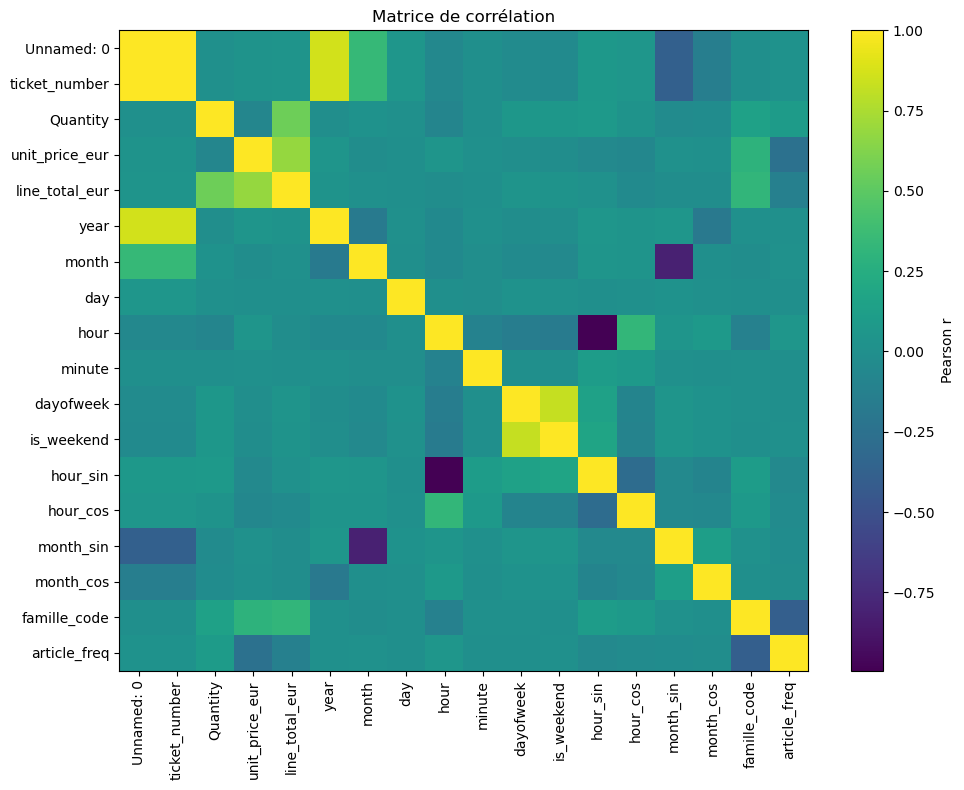

 Unnamed: 0       date  time  ticket_number              article  Quantity unit_price Famille_traditionnelle  unit_price_eur  line_total_eur            datetime  year  month  day  hour  minute  dayofweek  is_weekend  hour_sin  hour_cos  month_sin  month_cos  famille_code  article_freq
          0 2021-01-02 08:38         150040             BAGUETTE       1.0     0,90 €            Boulangerie            0.90            0.90 2021-01-02 08:38:00  2021      1    2     8      38          5           1  0.866025 -0.500000        0.5   0.866025             1      0.066051
          1 2021-01-02 08:38         150040     PAIN AU CHOCOLAT       3.0     1,20 €           Viennoiserie            1.20            3.60 2021-01-02 08:38:00  2021      1    2     8      38          5           1  0.866025 -0.500000        0.5   0.866025             5      0.045473
          4 2021-01-02 09:14         150041     PAIN AU CHOCOLAT       2.0     1,20 €           Viennoiserie            1.20            2.40 2

In [ ]:
df=df_bakery.copy()
# ticket_number -> entier (en gardant les NaN si nécessaire)
df["ticket_number"] = pd.to_numeric(df["ticket_number"], errors="coerce").astype("Int64")

# Quantity -> float
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")

# unit_price: transforme "0,90 €" -> 0.90 (euro)
df["unit_price_eur"] = (
    df["unit_price"]
      .astype(str)
      .str.replace(r"[^0-9,.\-]", "", regex=True)  # retire " €" etc.
      .str.replace(",", ".", regex=False)          # virgule -> point
      .replace("", np.nan)
      .astype(float)
)

# total de ligne
df["line_total_eur"] = df["Quantity"] * df["unit_price_eur"]

# --- 3) Features temporelles --------------------------------------------------
# Combine date + time en un datetime
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")

df["year"]      = df["datetime"].dt.year
df["month"]     = df["datetime"].dt.month
df["day"]       = df["datetime"].dt.day
df["hour"]      = df["datetime"].dt.hour
df["minute"]    = df["datetime"].dt.minute
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=lundi, 6=dimanche
df["is_weekend"]= df["dayofweek"].isin([5, 6]).astype(int)  # samedi/dimanche

# (Option recommandé pour corrélation) Encodage cyclique des heures & mois
# pour capturer la nature circulaire (23h proches de 0h, déc. proche de janv.)
df["hour_sin"]  = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]  = np.cos(2*np.pi*df["hour"]/24)
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# --- 4) Encodages catégoriels -------------------------------------------------
# Famille -> code numérique stable
df["famille_code"] = pd.Categorical(df["Famille_traditionnelle"]).codes

# (Option) One-hot si vous préférez des variables binaires:
famille_dummies = pd.get_dummies(df["Famille_traditionnelle"], prefix="famille", dtype=int)
# df = pd.concat([df, famille_dummies], axis=1)  # décommentez pour les ajouter

# Article -> encodage fréquentiel (fréquence d’apparition de l’article)
article_freq = df["article"].value_counts(normalize=True)
df["article_freq"] = df["article"].map(article_freq)


# --- 5) Sélectionner uniquement des colonnes numériques pour la corrélation ---
numeric_cols = [
    "Unnamed: 0", "ticket_number", "Quantity", "unit_price_eur", "line_total_eur",
    "year", "month", "day", "hour", "minute", "dayofweek", "is_weekend",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "famille_code", "article_freq"
]
df_num = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

corr = df_num.corr(method="pearson", numeric_only=True)

plt.figure(figsize=(10, 8))
# heatmap "pur" matplotlib (sans seaborn)
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Pearson r")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()




In [ ]:
# Regroupement par ticket
df_ticket = (
    df.groupby("ticket_number")
      .agg(
          total_spent=("line_total_eur", "sum"),
          total_quantity_articles=("Quantity", "sum"),
          datetime=("datetime", "min")   # on garde le moment du ticket
      )
      .reset_index()
)

# Recréer les variables temporelles à partir du datetime du ticket
df_ticket["year"]      = df_ticket["datetime"].dt.year
df_ticket["month"]     = df_ticket["datetime"].dt.month
df_ticket["day"]       = df_ticket["datetime"].dt.day
df_ticket["hour"]      = df_ticket["datetime"].dt.hour
df_ticket["minute"]    = df_ticket["datetime"].dt.minute
df_ticket["dayofweek"] = df_ticket["datetime"].dt.dayofweek
df_ticket["is_weekend"] = df_ticket["dayofweek"].isin([5, 6]).astype(int)

In [ ]:
df_ticket.to_csv("data_tmp/bakery_tickets.csv", index=False)